# Duration analysis

In [70]:
# Imports
%load_ext autoreload
%autoreload 2
from config import DRIVE_PATH_VIVA, label_clustering, content_categories
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import math
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
# Loading clean data already
period_data = pd.read_csv('data/derivatives/clean_viva.csv')
print(len(period_data))

# Creating figure path 
figures_path = os.path.join('data','figures', 'duration_analysis')    
os.makedirs(figures_path, exist_ok=True)

377320


In [72]:
period_data.head(2)

,Unnamed: 0.1,Unnamed: 0,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,...,title,upload_date,view_count,duration_in_min,channel_category,classified_category,upload_year,duration_bin,likes_per_view,dislikes_per_view
0,119,119,Education,UCzWBspFXaesJaWSXM27anuQ,2019-11-11 05:22:32.283250,Subscribe for 100’s of Free Drum Lessons! Drum...,2.0,LSNIXmhjrkg,354,40.0,...,Beginner Kick Groove Variation (PDF Available)...,2018-09-14 00:00:00,2603.0,5.9,Howto & Style,Music,2018,5-10,0.015367,0.000768
1,120,120,Education,UCzWBspFXaesJaWSXM27anuQ,2019-11-11 05:22:32.876127,Subscribe for 100’s of Free Drum Lessons! Drum...,0.0,KB3b2h61TYQ,300,47.0,...,Hand Freedom Groove (PDF Available) | Drum Les...,2018-09-13 00:00:00,1936.0,5.0,Howto & Style,Music,2018,5-10,0.024277,0.000000


### Processing

> - Print number of videos
> - Check duration
> - Get duration in minutes
> - After visualizing time distribution, 
> - Remove too small and too large videos?
> - Adding label column (classified / channel)
> - Add year channel
> - Create duration bins and add duration bin column
> - Select period
> - Add likes / dislikes / views for each videos (function in basic file)
> - Drop nans
> - Remove the keyword search for trash
> - Plot hist of duration bins



### Visualization

> - Boxplots of duration for the selected period 
> - Boxplot for likes/view or views vs duration
> - Napoleon plots for period, then per year and category, try finding trends
> - Barplots on metrics (year, total)
> - Finer metric plots (year, total)
> - OLS plots (year, total)


In [73]:
period = [2015, 2016, 2017, 2018]
duration_bin_titles = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-40', 
                       '40-50', '50-60', '60-90', '90-120', '>120']

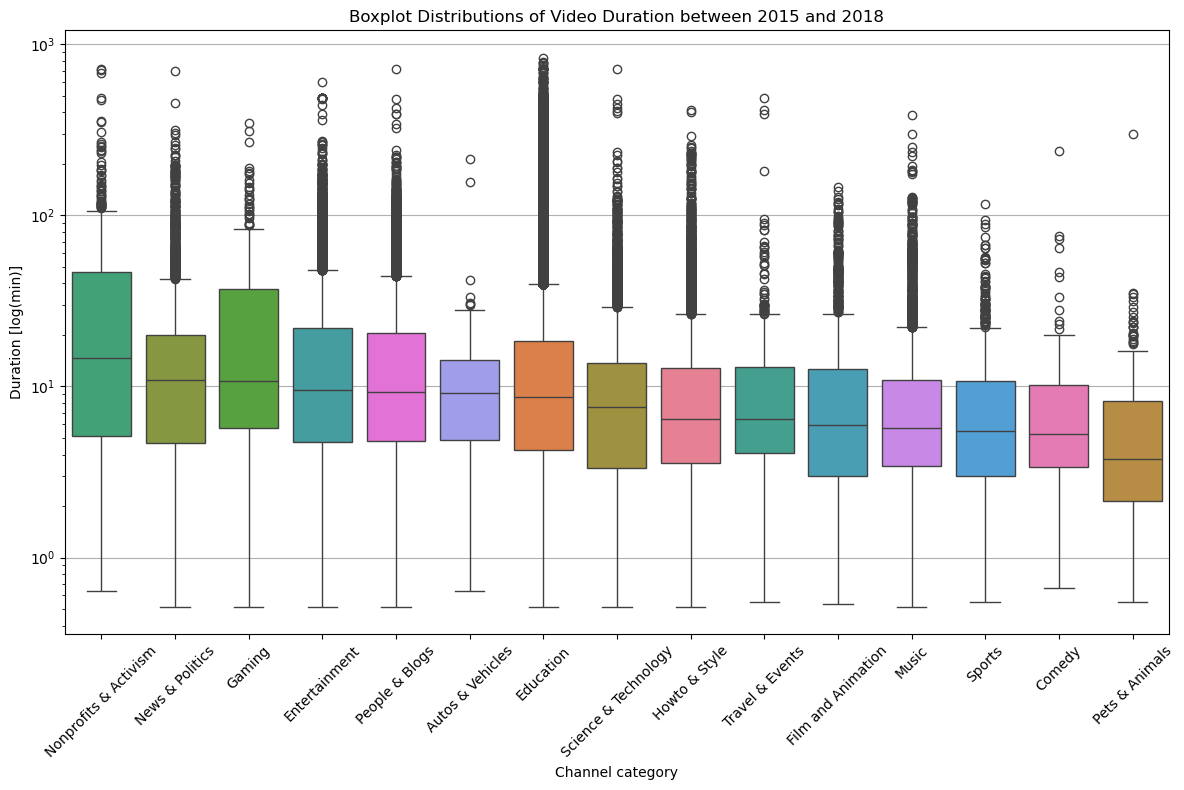

In [53]:
# Boxplots of duration for the selected period 
label_chosen = 'channel_category'

label_stats = period_data.groupby(label_chosen)['duration_in_min'].describe() # get the subjects with long context
medians = label_stats.sort_values(by='50%', ascending=False)['50%'] 

period_data[label_chosen] = period_data[label_chosen].astype(str)
medians.index = medians.index.astype(str)

fig, axs = plt.subplots(figsize=(12,8))
sns.boxplot(data=period_data, x=label_chosen, y='duration_in_min', hue =label_chosen, ax=axs, order = medians.index) # ordered by median 
plt.title(f'Boxplot Distributions of Video Duration between {period[0]} and {period[-1]}')
plt.xticks(rotation=45)
plt.xlabel('Channel category')
plt.yticks(np.arange(0, 1000, 100))
plt.ylabel('Duration [log(min)]')
plt.yscale('log')
axs.xaxis.grid(False)
axs.yaxis.grid(True)
plt.tight_layout()

plt.savefig(os.path.join(figures_path, f'boxplot_duration_{label_chosen}'))

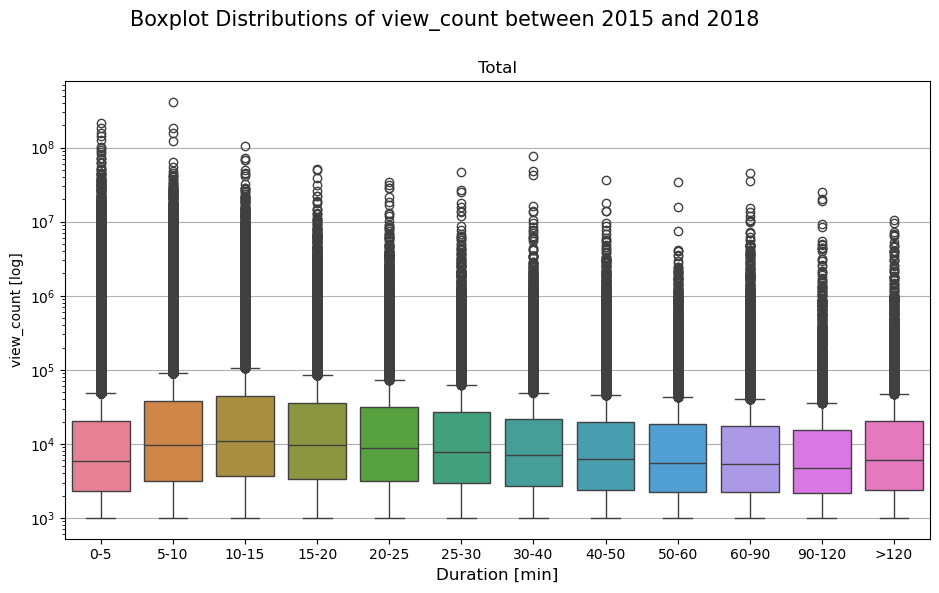

In [80]:
# Boxplot for likes/view or views vs duration
# === to solve issue of some categories not having videos long enough 
# Create a complete DataFrame with all combinations of categories and bins
categories = period_data['channel_category'].unique()
bins = period_data['duration_bin'].unique()
complete_index = pd.MultiIndex.from_product([categories, bins], names=['channel_category', 'duration_bin'])
complete_data = pd.DataFrame(index=complete_index).reset_index()

# Merge with the original data, filling missing combinations with NaN
period_data_complete = pd.merge(complete_data, period_data, on=['channel_category', 'duration_bin'], how='left')

# =======

label_chosen = 'channel_category'
metric = 'view_count'  # likes_per_view, dislikes_per_view, view_count

# Convert 'duration_bin' to a categorical type with the custom order
period_data_complete['duration_bin'] = pd.Categorical(period_data_complete['duration_bin'], 
                                                       categories=duration_bin_titles, 
                                                       ordered=True)

total_labels = list(period_data[label_chosen].value_counts().index)
n_plots = len(total_labels)

#fig, axs = plt.subplots(n_plots + 1, 1, figsize=(20, 80), sharex=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)

sns.boxplot(data=period_data_complete, x='duration_bin', y=metric, hue='duration_bin', ax=ax)
ax.set_title('Total')


ax.xaxis.grid(False)
ax.yaxis.grid(True)
ax.set_yscale('log')
ax.set_ylabel(f'{metric} [log]', fontsize=10)

plt.xlabel('Duration [min]', fontsize=12)
plt.suptitle(f'Boxplot Distributions of {metric} between {period[0]} and {period[-1]}', fontsize=15)
plt.tight_layout(rect=[0.05, 0, 1, 0.98])  # adjust the layout to avoid overlapping
plt.savefig(os.path.join(figures_path, f'boxplot_{metric}_{label_chosen}_total'), dpi = 300)


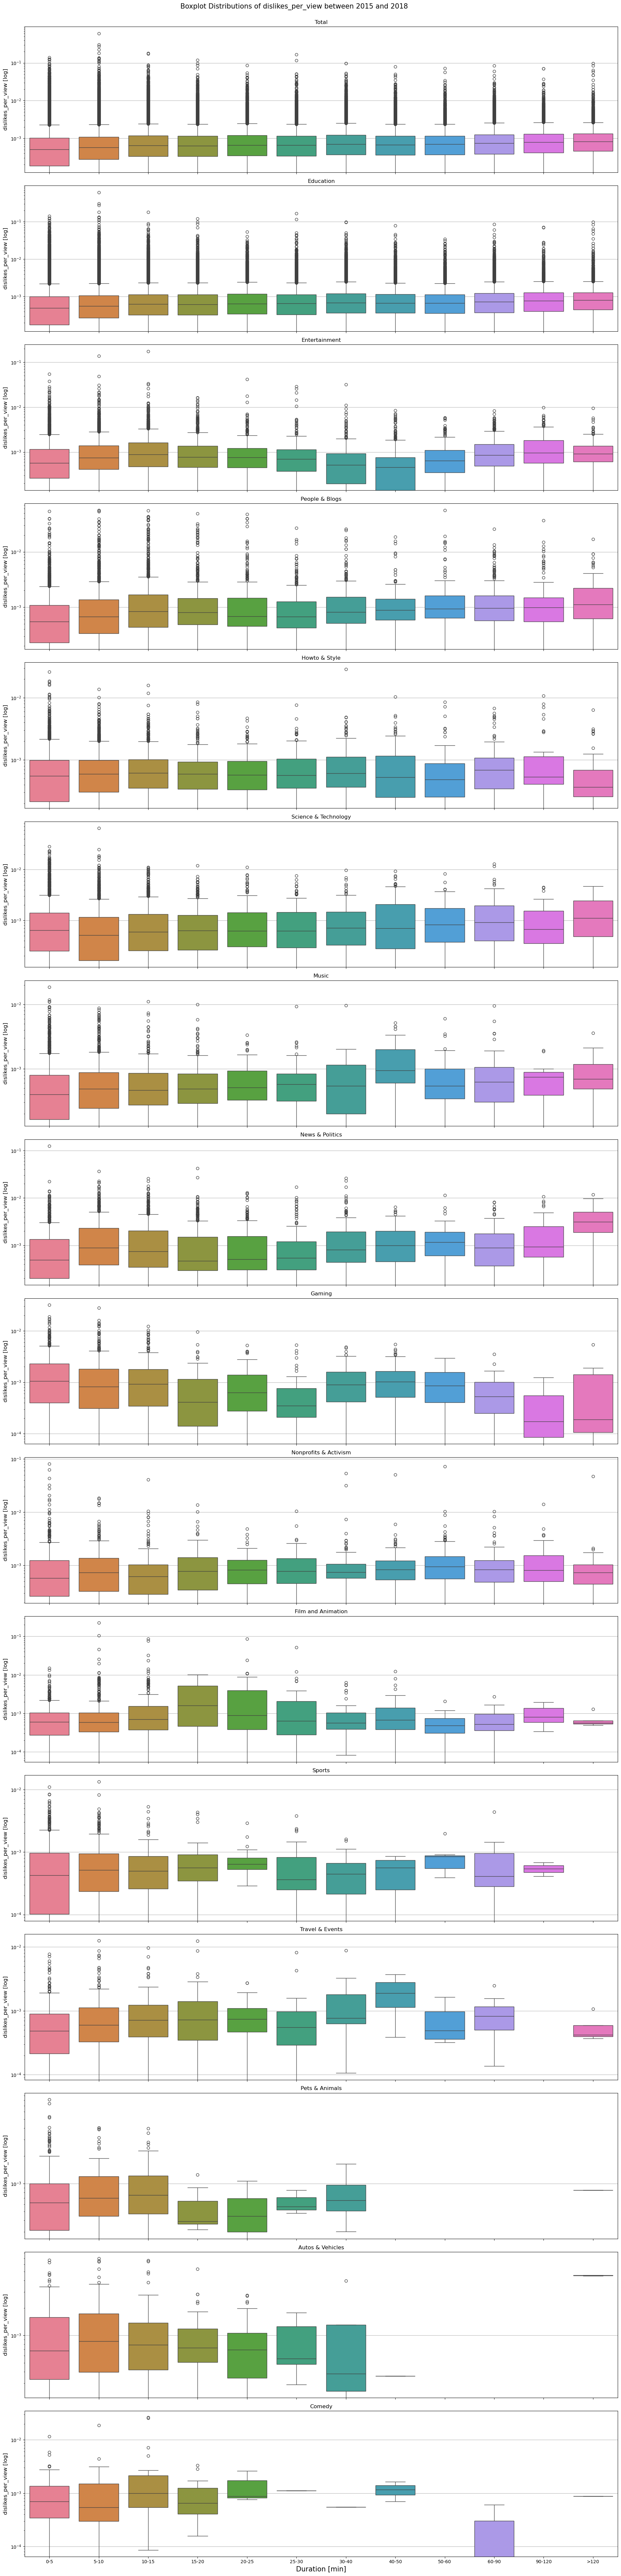

In [81]:
# Boxplot for likes/view or views vs duration
# === to solve issue of some categories not having videos long enough 
# Create a complete DataFrame with all combinations of categories and bins
categories = period_data['channel_category'].unique()
bins = period_data['duration_bin'].unique()
complete_index = pd.MultiIndex.from_product([categories, bins], names=['channel_category', 'duration_bin'])
complete_data = pd.DataFrame(index=complete_index).reset_index()

# Merge with the original data, filling missing combinations with NaN
period_data_complete = pd.merge(complete_data, period_data, on=['channel_category', 'duration_bin'], how='left')

# =======

label_chosen = 'channel_category'
metric = 'dislikes_per_view'  # likes_per_view, dislikes_per_view, view_count

# Convert 'duration_bin' to a categorical type with the custom order
period_data_complete['duration_bin'] = pd.Categorical(period_data_complete['duration_bin'], 
                                                       categories=duration_bin_titles, 
                                                       ordered=True)

total_labels = list(period_data[label_chosen].value_counts().index)
n_plots = len(total_labels)

fig, axs = plt.subplots(n_plots + 1, 1, figsize=(20, 80), sharex=True)

for i, ax in enumerate(axs):
    if i == 0:
        sns.boxplot(data=period_data_complete, x='duration_bin', y=metric, hue='duration_bin', ax=ax)
        ax.set_title('Total')
    else:
        sns.boxplot(data=period_data_complete[period_data_complete[label_chosen] == total_labels[i - 1]], 
                    x='duration_bin', y=metric, hue='duration_bin', ax=ax)
        ax.set_title(total_labels[i - 1])

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set_yscale('log')
    ax.set_ylabel(f'{metric} [log]', fontsize=12)

plt.xlabel('Duration [min]', fontsize=15)
plt.suptitle(f'Boxplot Distributions of {metric} between {period[0]} and {period[-1]}', fontsize=15)
plt.tight_layout(rect=[0.05, 0, 1, 0.98])  # adjust the layout to avoid overlapping
plt.savefig(os.path.join(figures_path, f'boxplot_{metric}_{label_chosen}_total'), dpi = 300)


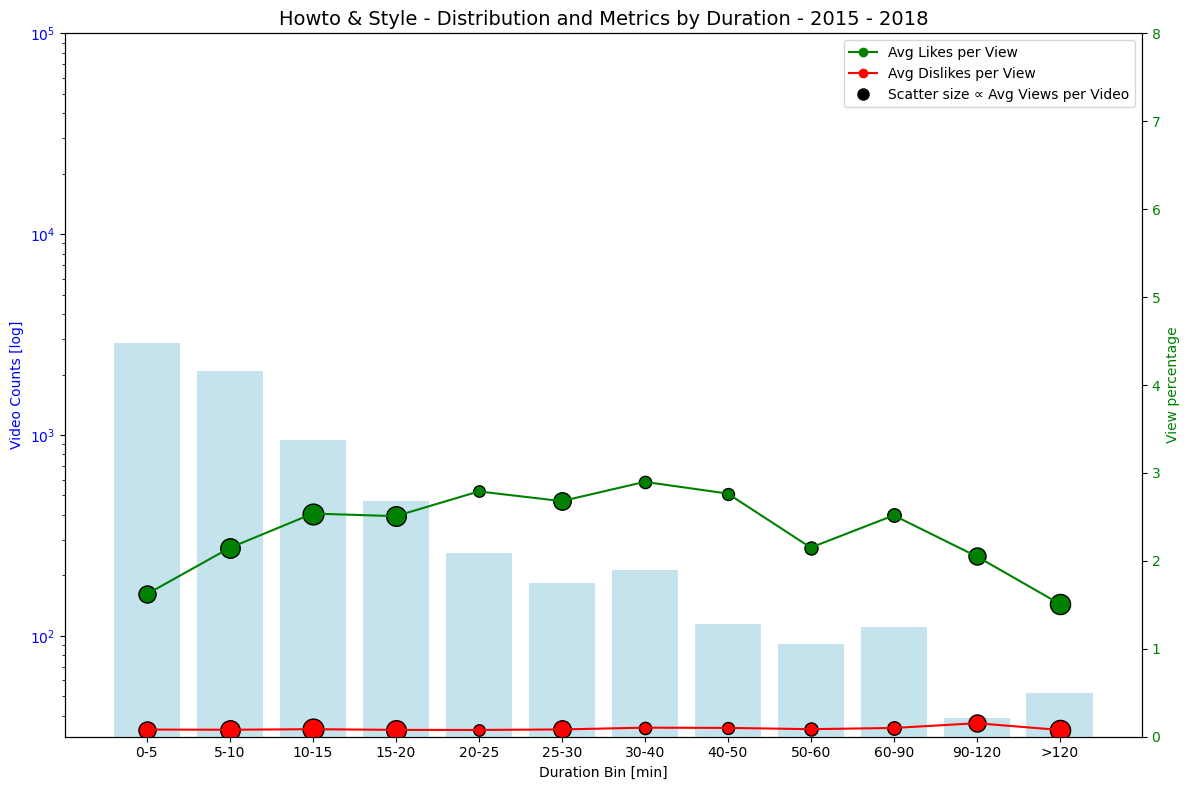

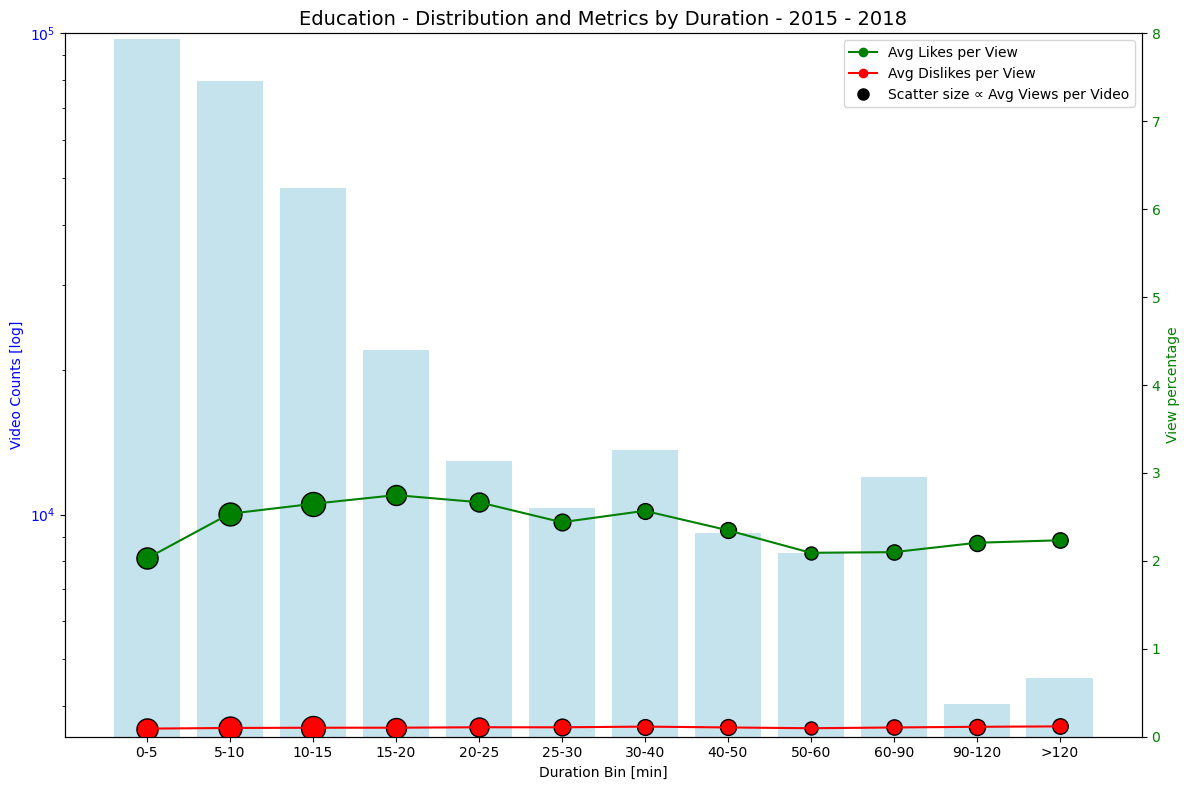

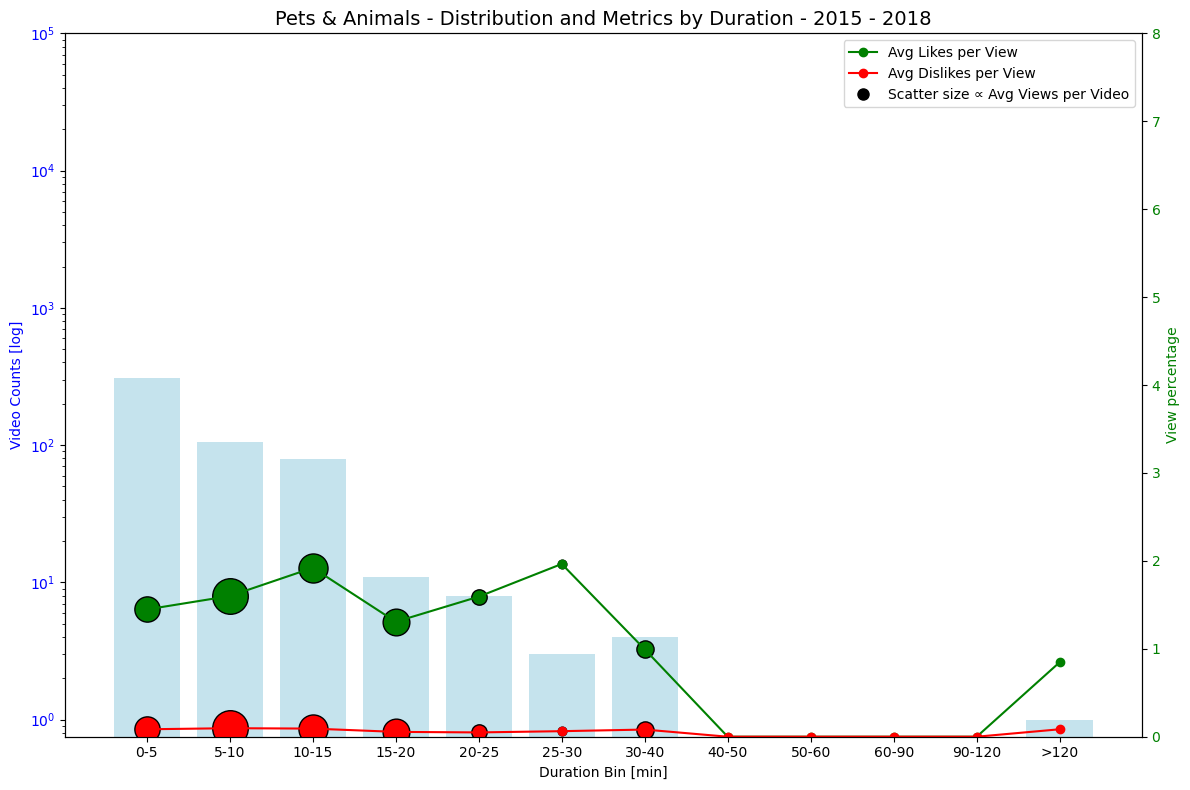

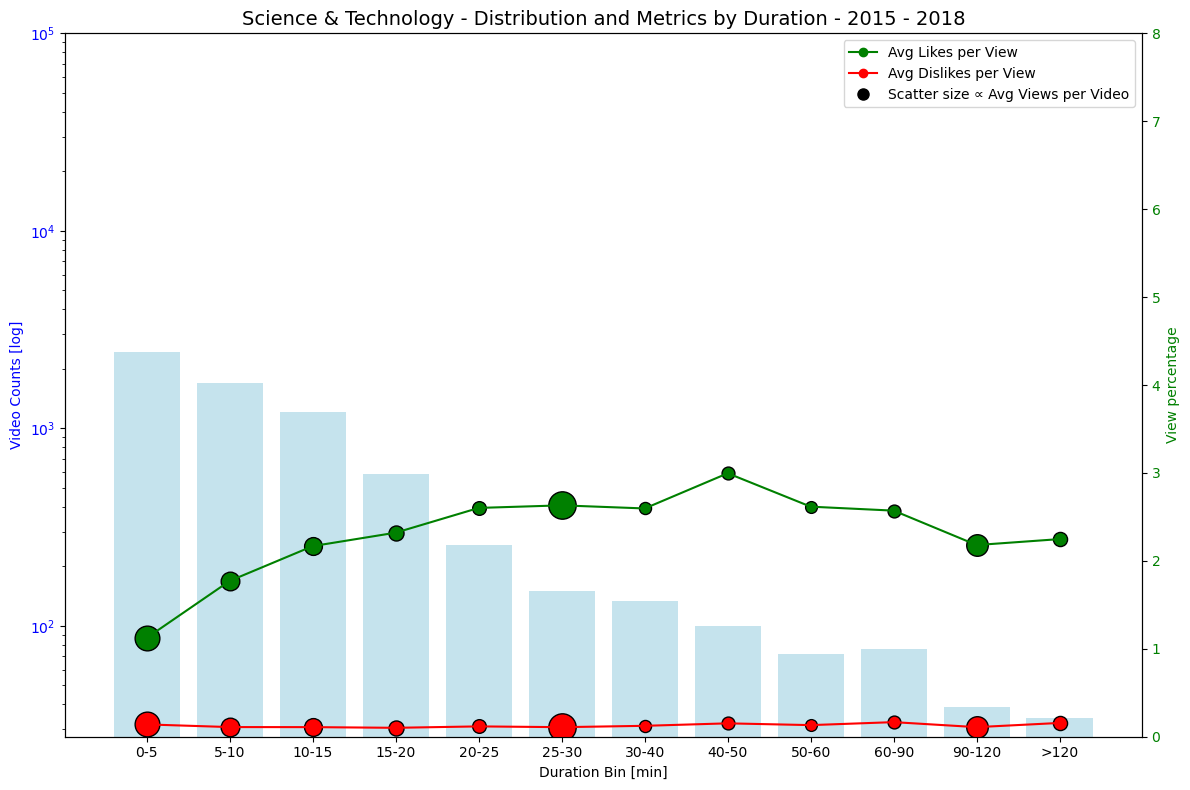

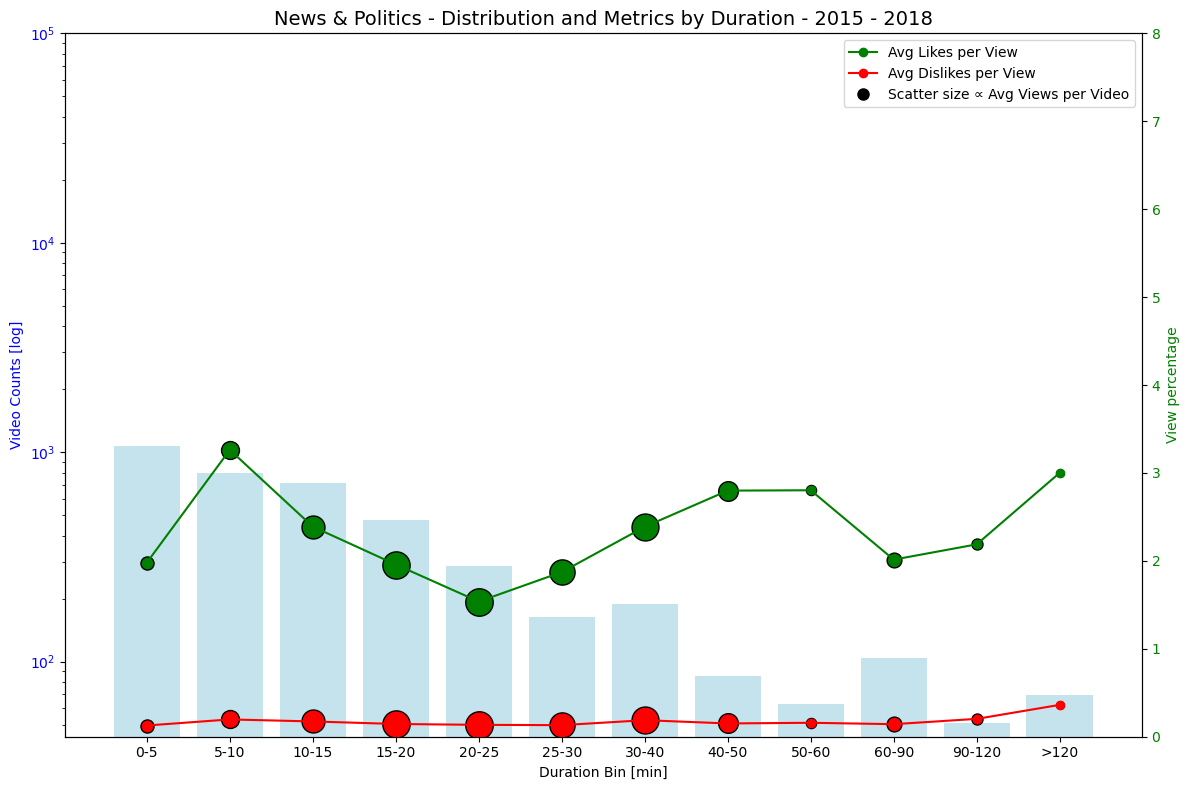

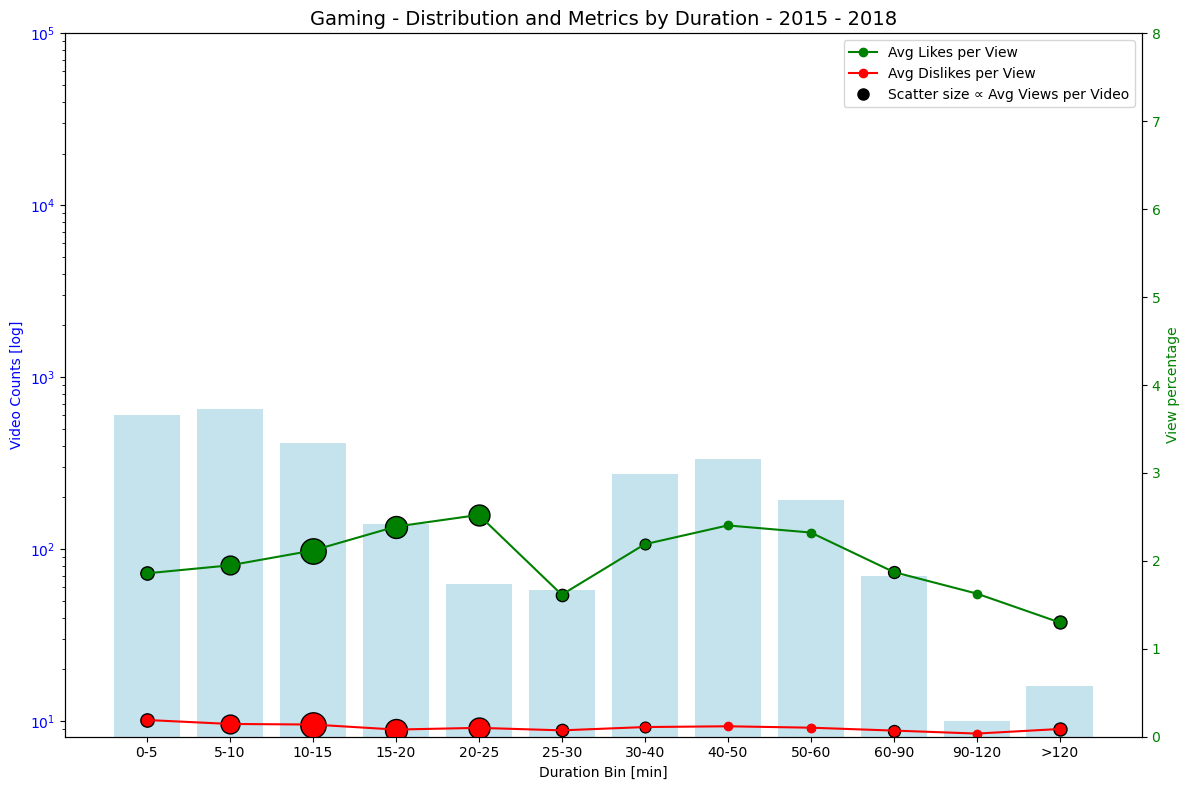

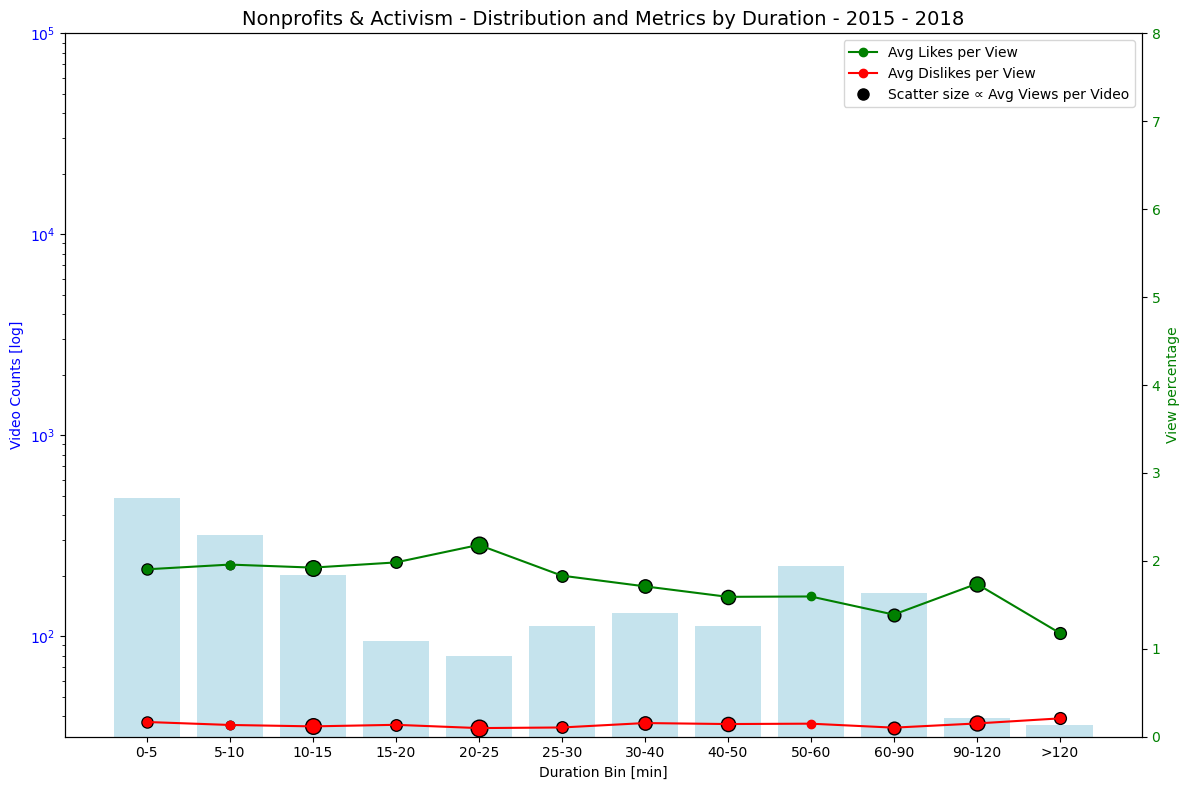

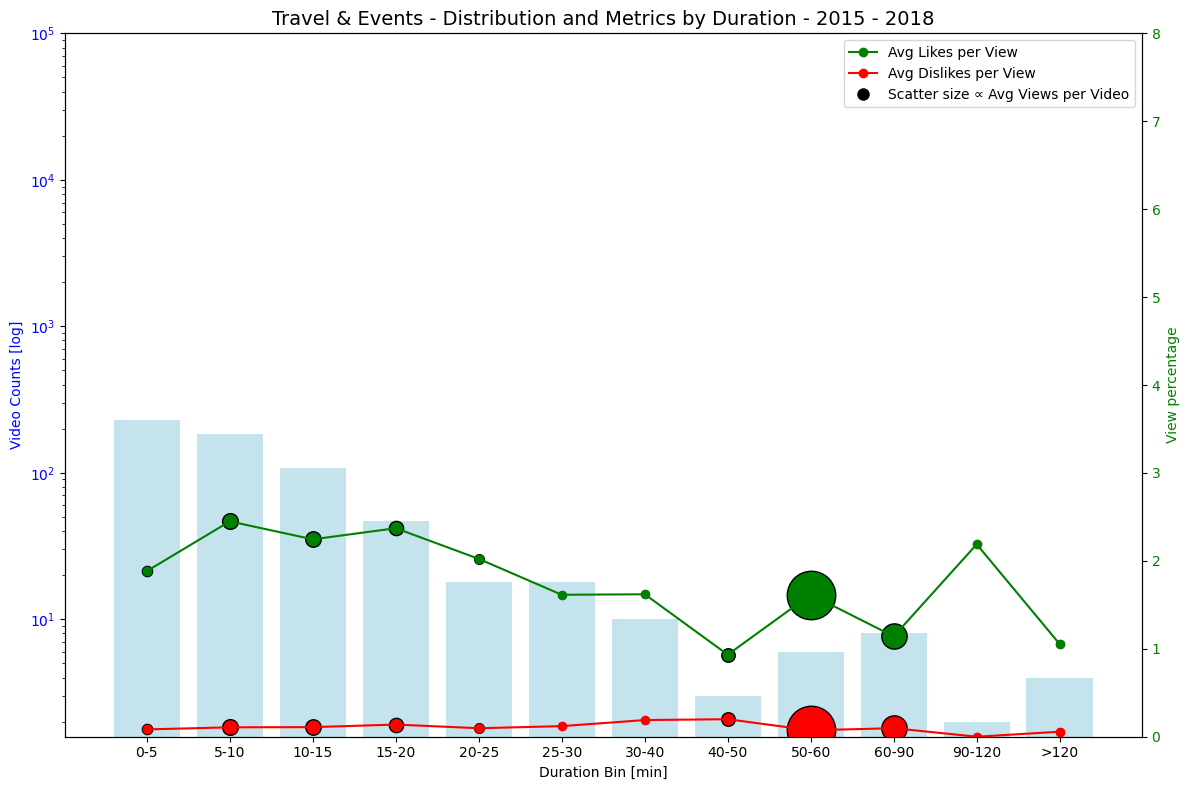

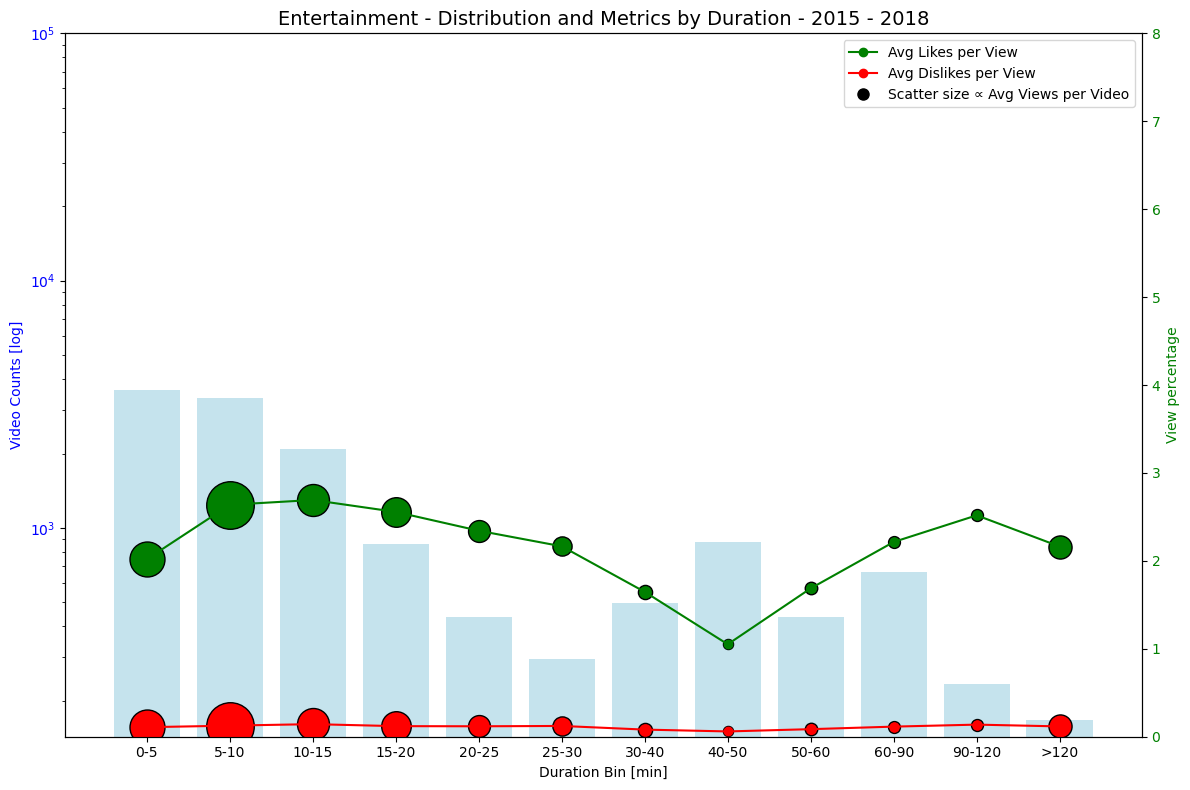

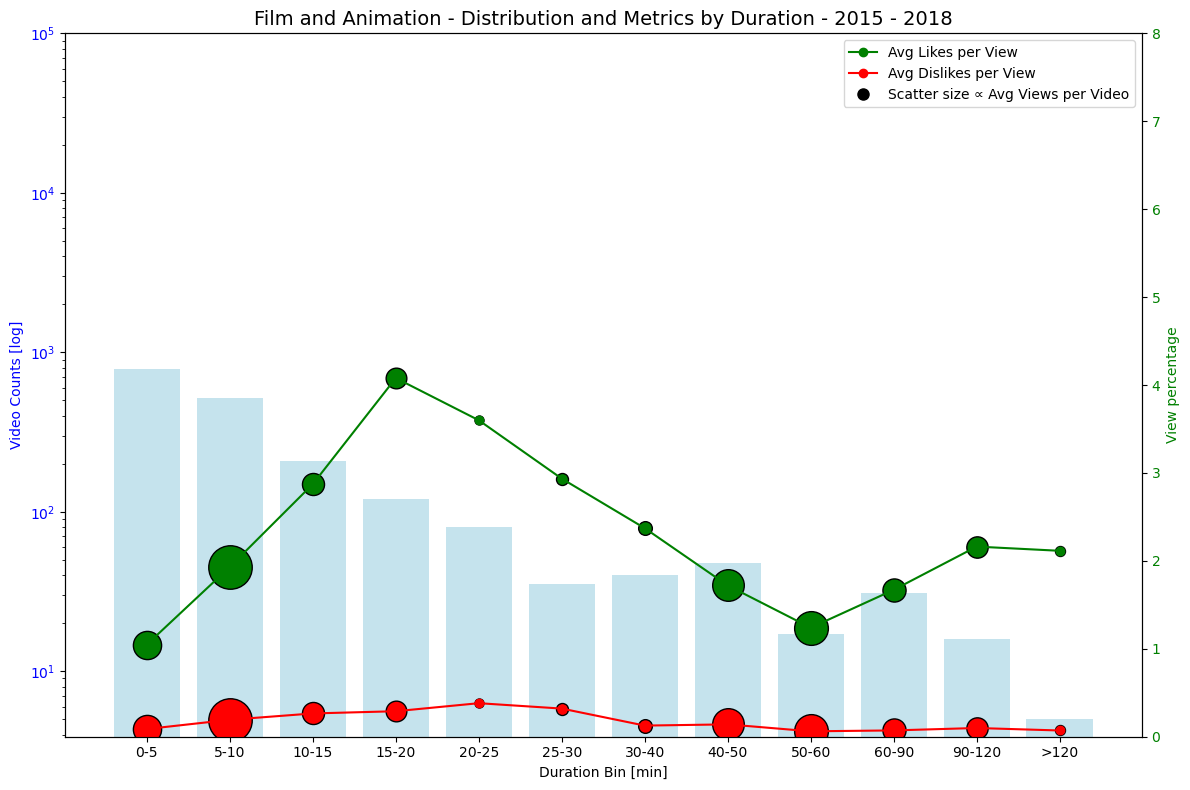

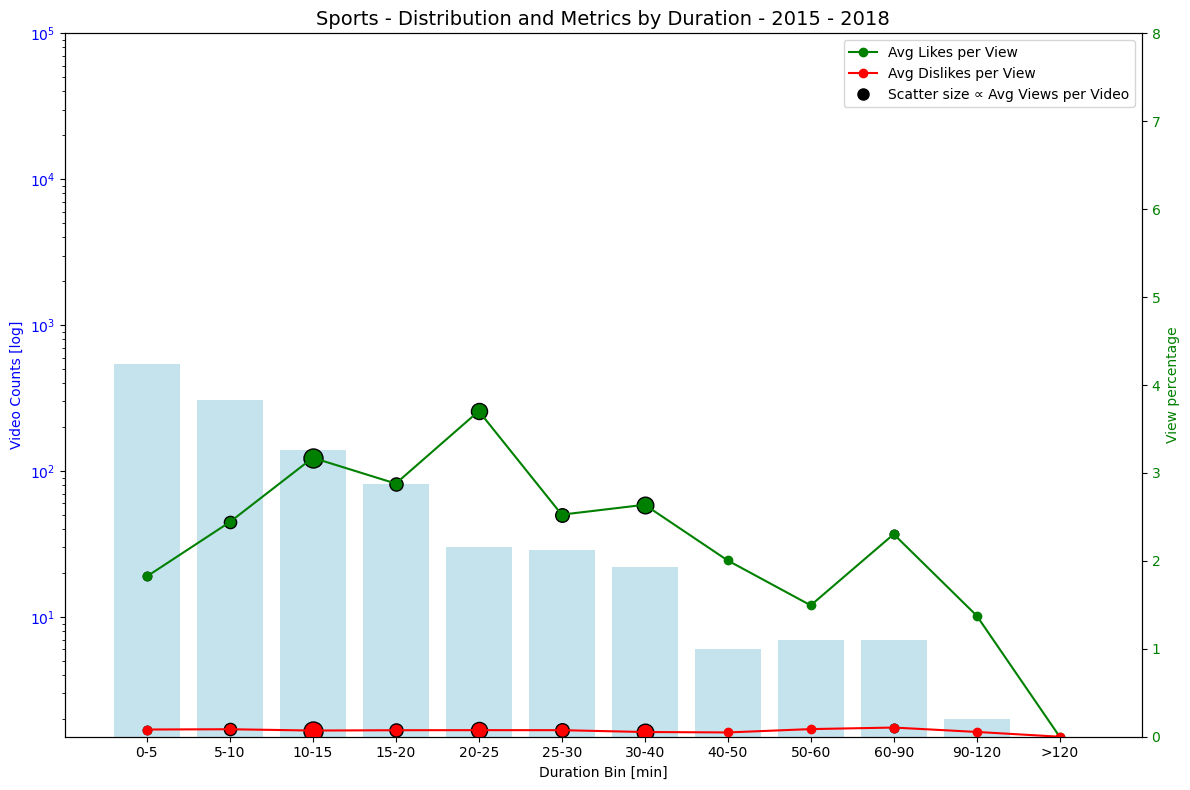

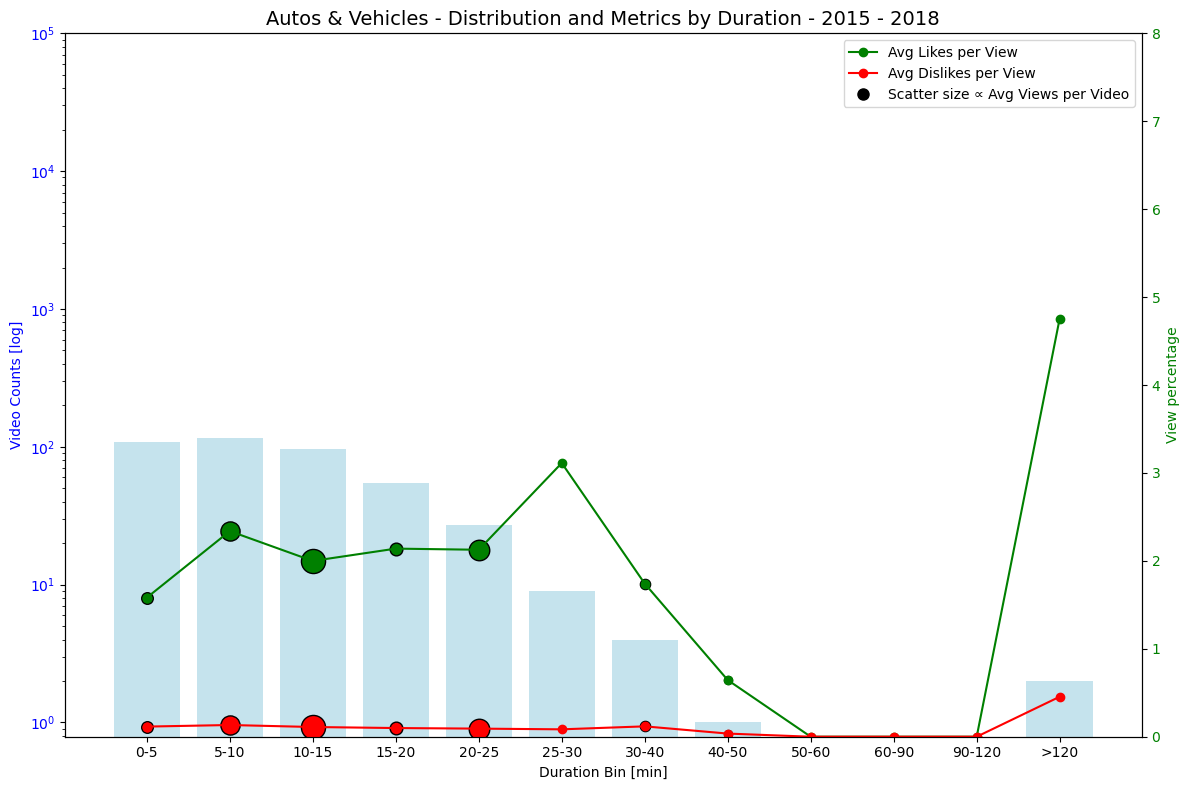

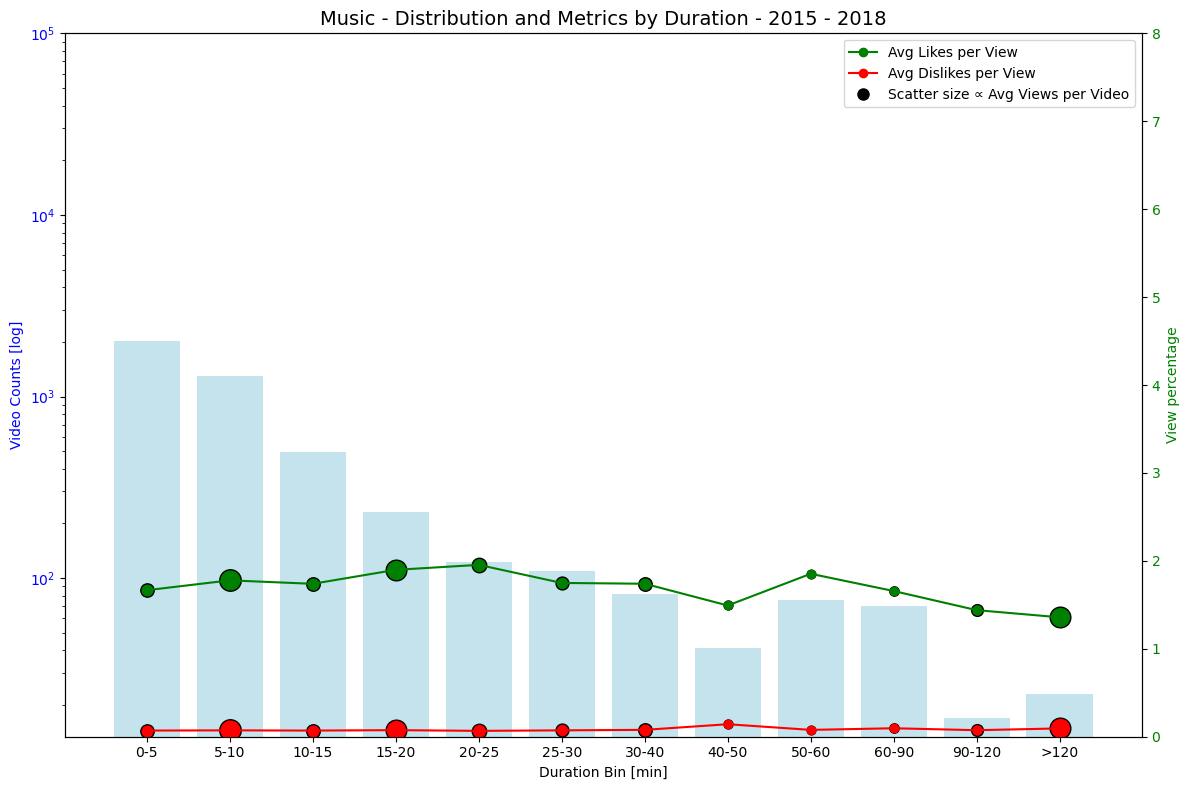

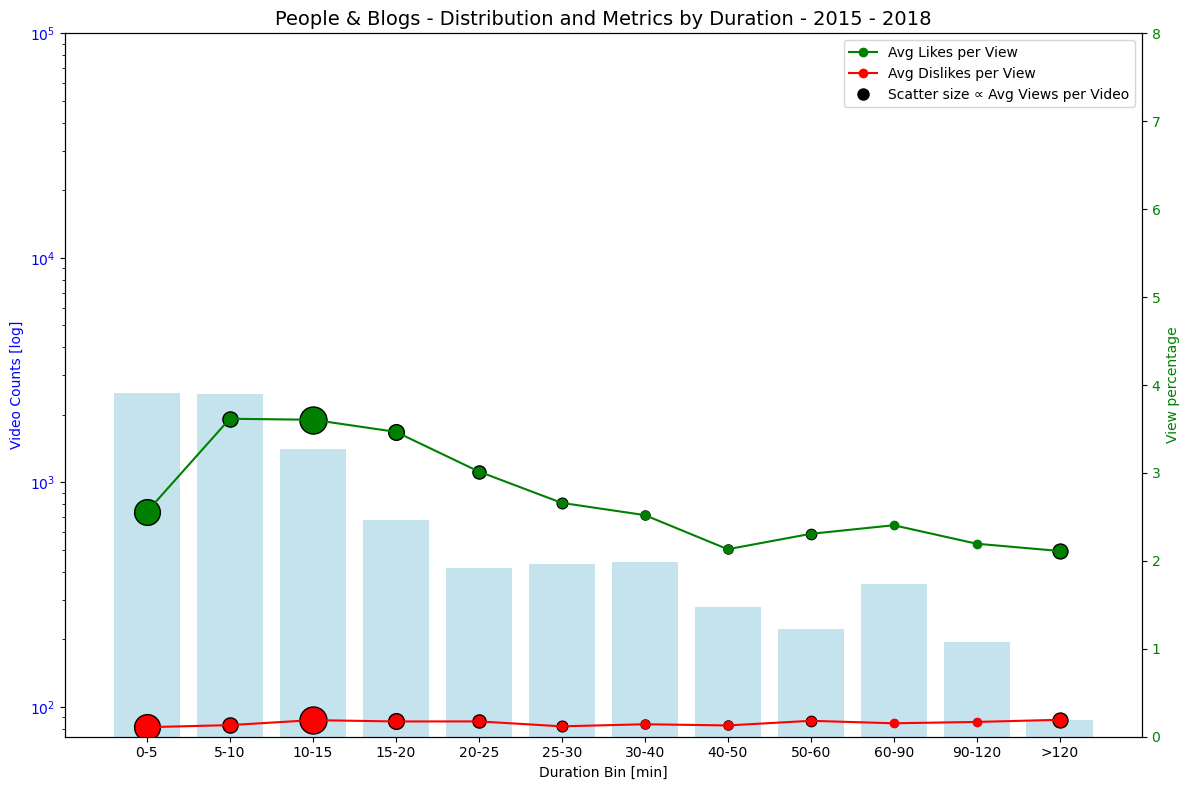

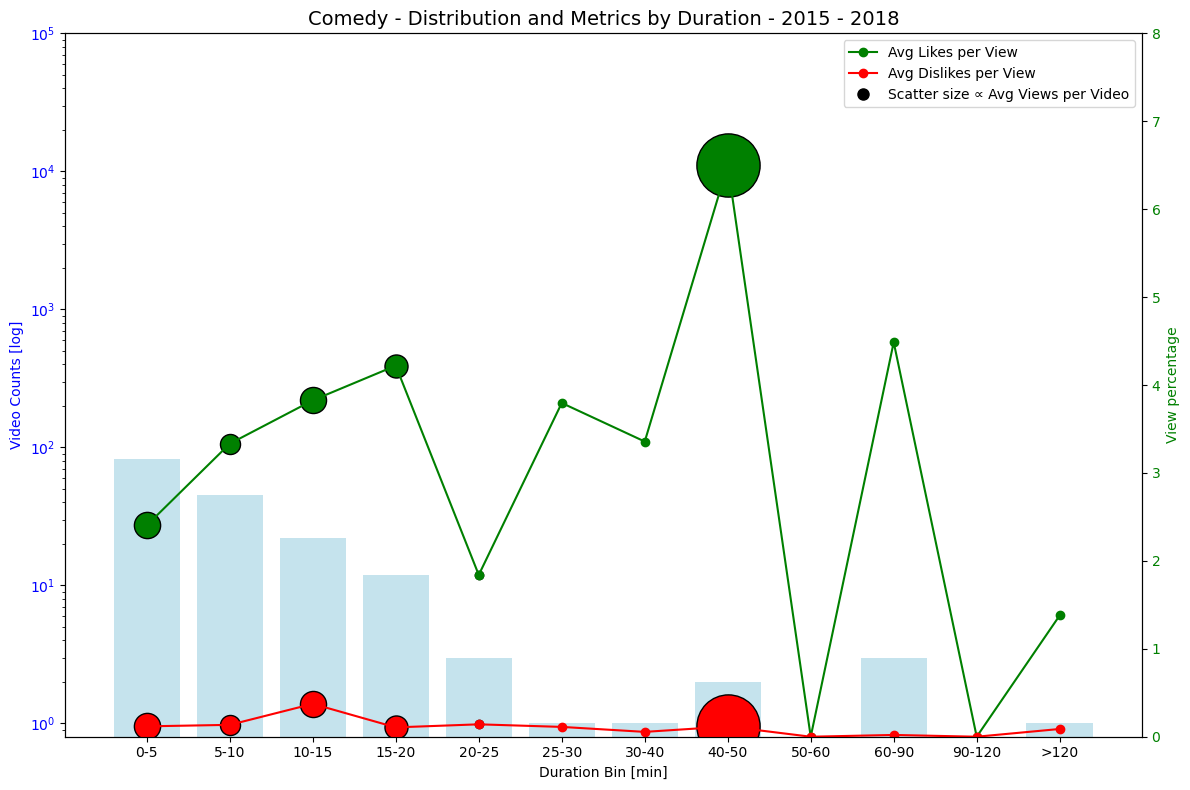

In [64]:
# Napoleon plots for period and category
categories = list(period_data['channel_category'].unique())

for category in categories:
    cat_data = period_data[period_data['channel_category'] == category]

    # Convert 'duration_bin' to a categorical type with the custom order
    cat_data['duration_bin'] = pd.Categorical(cat_data['duration_bin'], categories=duration_bin_titles, ordered=True)

    # Compute metrics
    bin_counts = cat_data.groupby('duration_bin')['duration_bin'].count()
    likes_per_view = cat_data.groupby('duration_bin')['likes_per_view'].mean()
    dislikes_per_view = cat_data.groupby('duration_bin')['dislikes_per_view'].mean()
    avg_views_per_video = cat_data.groupby('duration_bin')['view_count'].mean()

    # Handle NaN values
    likes_per_view = np.array([0 if math.isnan(x) else x for x in likes_per_view])
    dislikes_per_view = np.array([0 if math.isnan(x) else x for x in dislikes_per_view])
    avg_views_per_video = np.array([0 if math.isnan(x) else x for x in avg_views_per_video])

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Bar plot for video counts (ensure sorting by 'duration_bin' order)
    ax.bar(bin_counts.index, bin_counts.values, color='lightblue', alpha=0.7, label='Video Counts')
    ax.set_ylabel('Video Counts [log]', color='blue')
    ax.set_yscale('log')
    ax.set_ylim(0, 100000)
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_xlabel('Duration Bin [min]')

    # Create secondary y-axis for likes and dislikes per view
    ax2 = ax.twinx()
    
    ax2.plot(bin_counts.index, likes_per_view * 100, color='green', marker='o', label='Avg Likes per View', linestyle='-')
    ax2.plot(bin_counts.index, dislikes_per_view * 100, color='red', marker='o', label='Avg Dislikes per View', linestyle='-')

    ax2.set_ylabel('View percentage', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim(0, 8) 

    # Add points with sizes based on average views per video
    for x, y_likes, y_dislikes, size in zip(bin_counts.index, likes_per_view, dislikes_per_view, avg_views_per_video):
        ax2.scatter(x, y_likes * 100, s=(size / 500), color='green', alpha=1, edgecolor='black')  # Scale size appropriately
        ax2.scatter(x, y_dislikes * 100, s=(size / 500), color='red', alpha=1, edgecolor='black')

    # Legend for scatter size
    size_legend = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Scatter size ∝ Avg Views per Video')

    ax.set_title(f'{category} - Distribution and Metrics by Duration - {period[0]} - {period[-1]}', fontsize=14)
    ax2.legend(handles=ax2.get_legend_handles_labels()[0] + [size_legend], loc='upper right')
    
    plt.tight_layout()
    path_to_fig = os.path.join(figures_path, 'Napoleon_plot', f'period_{period[0]}_{period[-1]}')
    os.makedirs(path_to_fig, exist_ok=True)
    
    plt.savefig(os.path.join(path_to_fig, category))



In [66]:
# Napoleon plots per category 
for category in period_data['channel_category'].unique():
    cat_data = period_data[period_data['channel_category'] == category]
    cat_data['duration_bin'] = pd.Categorical(cat_data['duration_bin'], categories=duration_bin_titles, ordered=True)
    years = sorted(cat_data['upload_year'].unique())

    n_years = len(years)
    fig, axs = plt.subplots(n_years, 1, figsize=(12, 8 * n_years), sharex=True)

    if n_years == 1:  
        axs = [axs]

    for i, year in enumerate(years):
        year_data = cat_data[cat_data['upload_year'] == year]

        # Compute metrics
        bin_counts = year_data.groupby('duration_bin')['duration_bin'].count()
        likes_per_view = year_data.groupby('duration_bin')['likes_per_view'].mean()
        dislikes_per_view = year_data.groupby('duration_bin')['dislikes_per_view'].mean()
        avg_views_per_video = year_data.groupby('duration_bin')['view_count'].mean()

        likes_per_view = np.array([0 if math.isnan(x) else x for x in likes_per_view])
        dislikes_per_view = np.array([0 if math.isnan(x) else x for x in dislikes_per_view])
        avg_views_per_video = np.array([0 if math.isnan(x) else x for x in avg_views_per_video])

        ax = axs[i]
        ax.bar(bin_counts.index, bin_counts.values, color='lightblue', alpha=0.7, label='Video Counts')
        ax.set_ylabel('Video Counts [log]', color='blue')
        ax.set_yscale('log')
        ax.set_ylim(0, 100000)
        ax.tick_params(axis='y', labelcolor='blue')
        ax.set_xlabel('Duration Bin [min]')

        ax2 = ax.twinx()
        ax2.plot(bin_counts.index, likes_per_view * 100, color='green', marker='o', label='Avg Likes per View', linestyle='-')
        ax2.plot(bin_counts.index, dislikes_per_view * 100, color='red', marker='o', label='Avg Dislikes per View', linestyle='-')
        ax2.set_ylabel('View Percentage [%]', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.set_ylim(0, 8)
        
        # Add points with sizes based on average views per video
        for x, y_likes, y_dislikes, size in zip(bin_counts.index, likes_per_view, dislikes_per_view, avg_views_per_video):
            ax2.scatter(x, y_likes * 100, s=(size / 500), color='green', alpha=1, edgecolor='black')  # Scale size appropriately
            ax2.scatter(x, y_dislikes * 100, s=(size / 500), color='red', alpha=1, edgecolor='black')

        # Add a legend entry for scatter size with a black circle
        size_legend = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Scatter size ∝ Avg Views per Video')

        # Titles and legends
        ax.set_title(f'{year}', fontsize=14)
        if i == 0:  # Add the legend only once
            ax2.legend(handles=ax2.get_legend_handles_labels()[0] + [size_legend], loc='upper right')

    # Save the plot
    plt.suptitle(f'{category} distribution and metrics by duration', fontsize = 15)
    plt.tight_layout(rect=[0.05, 0, 1, 0.98])
    path_to_fig = os.path.join(figures_path, 'Napoleon_plot', 'per_category')
    os.makedirs(path_to_fig, exist_ok=True)
    plt.savefig(os.path.join(path_to_fig, f'{category}.png'))



## Analysis

> - Looking at Mutual Information, Pearson and Spearman correlation


In [57]:
view_stats = {'spearman': [], 'pearson': [], 'mutual_info': []}
like_stats = {'spearman': [], 'pearson': [], 'mutual_info': []}

def update_stats(stat_dic, spearman, pearson, mi):
    stat_dic['spearman'].append(spearman)
    stat_dic['pearson'].append(pearson)
    stat_dic['mutual_info'].append(mi)

for category in categories:
    cat_data = period_data[period_data['channel_category'] == category]
    
    x = cat_data['duration_in_min']
    y_likes = cat_data['likes_per_view']
    y_views = cat_data['view_count']
    
    pearson_corr_likes, _ = pearsonr(x, y_likes)
    spearman_corr_likes, _ = spearmanr(x, y_likes)
    mi_likes = mutual_info_regression(x.values.reshape(-1, 1), y_likes)
    update_stats(like_stats, pearson_corr_likes, spearman_corr_likes, mi_likes)
    pearson_corr_views, _ = pearsonr(x, y_views)
    spearman_corr_views, _ = spearmanr(x, y_views)
    mi_views = mutual_info_regression(x.values.reshape(-1, 1), y_views)
    update_stats(view_stats, pearson_corr_views, spearman_corr_views, mi_views)
    
    
    

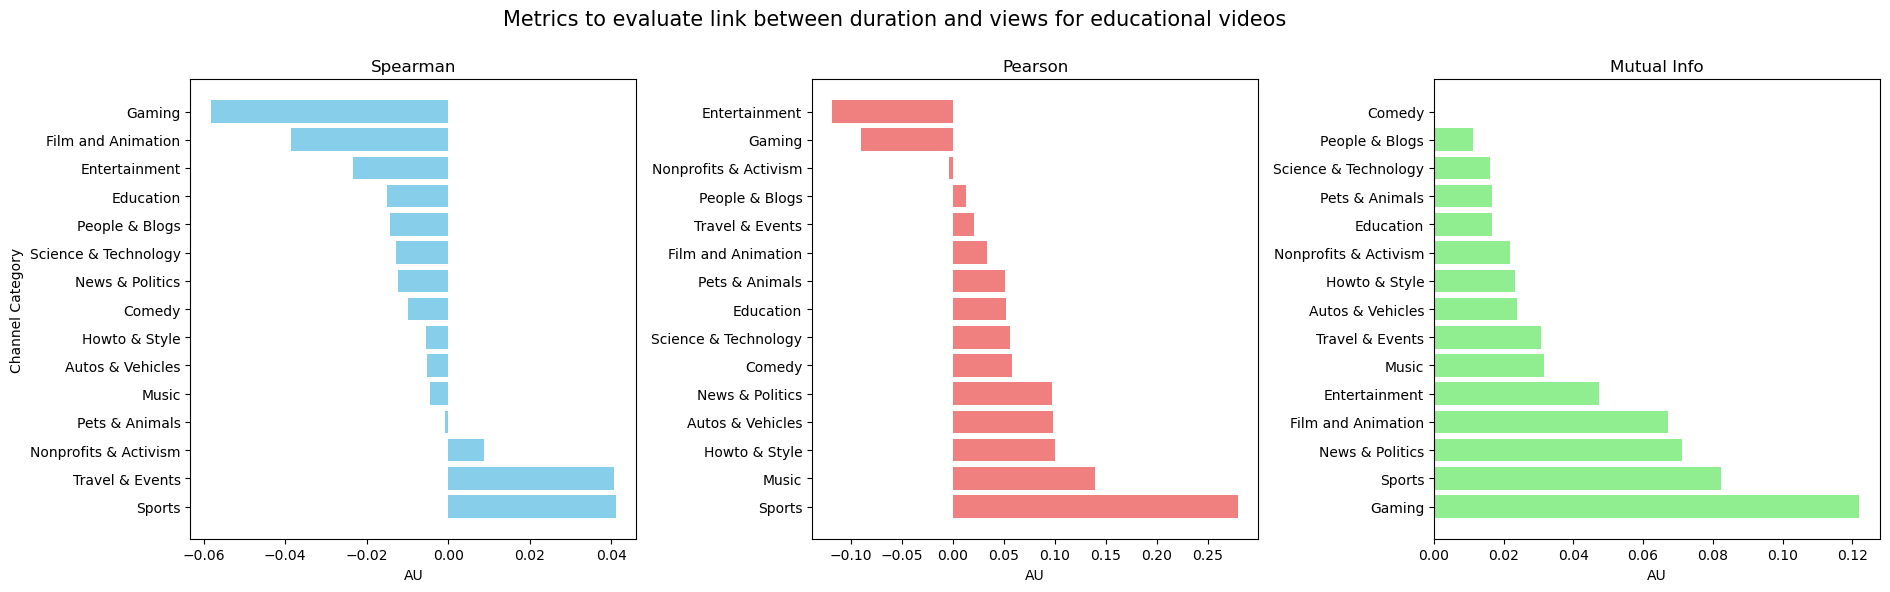

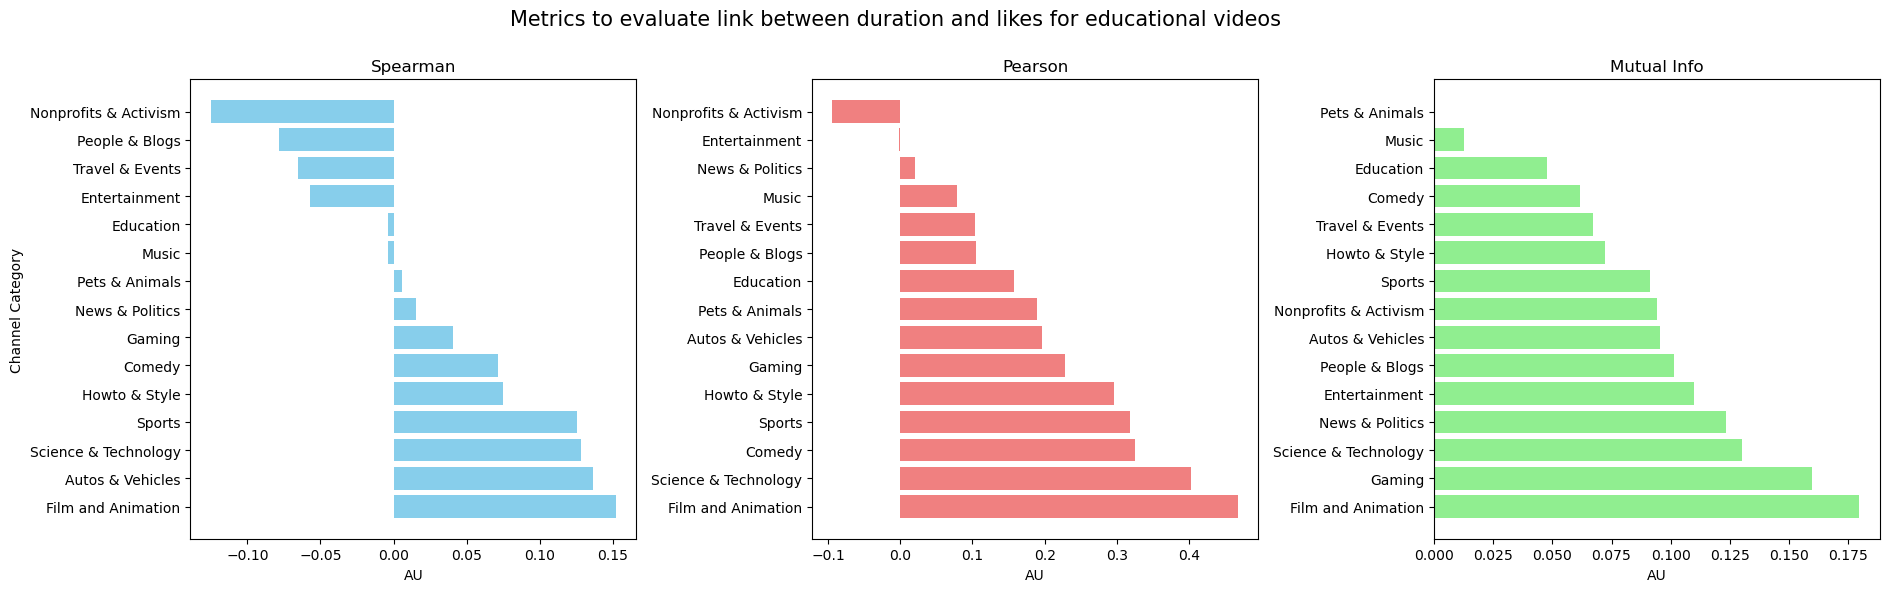

In [59]:
# Flatten the mutual_info values before creating the DataFrame
view_stats['mutual_info'] = [mi[0] if isinstance(mi, np.ndarray) else mi for mi in view_stats['mutual_info']]
like_stats['mutual_info'] = [mi[0] if isinstance(mi, np.ndarray) else mi for mi in like_stats['mutual_info']]

# Convert stats dictionaries to DataFrames and add categories as index
view_stats_df = pd.DataFrame(view_stats, index=categories)
like_stats_df = pd.DataFrame(like_stats, index=categories)

# Define metrics and their labels
metrics = ['spearman', 'pearson', 'mutual_info']
metric_labels = ['Spearman', 'Pearson', 'Mutual Info']
colors = ['skyblue', 'lightcoral', 'lightgreen']  # Consistent color scheme for metrics

# Function to create subplots for sorted horizontal bar plots, sorting by Pearson correlation
def create_metric_subplots(stats_df, metric_labels, colors, title_prefix, save_path):
    # Sort by Pearson correlation
    sorted_data = stats_df.sort_values(by='pearson', ascending=False)
    
    # Create subplots for each metric, no shared y-axis
    fig, axs = plt.subplots(1, len(metrics), figsize=(20, 6), sharey=False)

    for i, metric in enumerate(metrics):
        # Sort the data by the current metric in descending order
        sorted_metric_data = sorted_data.sort_values(by=metric, ascending=False)
        
        # Horizontal bar plot for each metric
        axs[i].barh(sorted_metric_data.index, sorted_metric_data[metric], color=colors[i])
        axs[i].set_title(f'{metric_labels[i]}')
        axs[i].set_xlabel('AU')  # x-axis shows metric value
        if i == 0:  # Add y-axis labels only to the first subplot
            axs[i].set_ylabel('Channel Category')
        axs[i].tick_params(axis='y', rotation=0)

        # Ensure the x-axis limits are consistent across all subplots for comparison
        #axs[i].set_xlim(0, 1)  # Example of consistent x-limits, adjust as needed

    plt.suptitle(f'Metrics to evaluate link between duration and {title_prefix.lower()} for educational videos', fontsize=15)
    plt.tight_layout(rect=[0.05, 0, 1, 0.98])
    plt.savefig(save_path)
    
path_to_fig = os.path.join(figures_path, 'metrics')
os.makedirs(path_to_fig, exist_ok=True)

# Create horizontal bar plots for view metrics
create_metric_subplots(
    view_stats_df,
    metric_labels,
    colors,
    title_prefix='Views',
    save_path=os.path.join(path_to_fig, 'views_vs_duration')
)

# Create horizontal bar plots for like metrics
create_metric_subplots(
    like_stats_df,
    metric_labels,
    colors,
    title_prefix='Likes',
    save_path=os.path.join(path_to_fig, 'likes_vs_duration')
)
